# Downloading the dataset

In [1]:
import kagglehub

root = kagglehub.dataset_download("dani215/fire-dataset") + "\\fire_dataset/"
print("Path to dataset files:", root)

D:\College\Fall2024\COMPSCI_4AL3\Fire-Image-Classification\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\suvan\.cache\kagglehub\datasets\dani215\fire-dataset\versions\1\fire_dataset/


# Importing the libraries

In [2]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Transformations and Hyperparameters

In [3]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Batch size
batch_size = 64
# Must be a float between 0 and 1
train_size = 0.7 # Train size
val_size = 0.15 # Validation size
test_size = 0.15 # Test size
# Learning rate
lr = 0.001
# Number of epochs
num_epochs = 100

# Optional path to the dataset
# root = "fire_dataset/"

# Transformations
transformations = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Dataset and DataLoader

In [4]:
class FireDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.image_paths = []
        self.labels = []

        for label, class_name in enumerate(self.classes):
            class_folder = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_folder):
                self.image_paths.append(os.path.join(class_folder, img_name))
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32).unsqueeze(0)

# Splitting the dataset
fire_dataset = FireDataset(root_dir=root, transform=transformations)
train_dataset, test_dataset, validation_dataset = random_split(fire_dataset, [train_size, test_size, val_size])
print("Dataset size:", len(fire_dataset))
print("Train size:", len(train_dataset))
print("Validation size:", len(validation_dataset))
print("Test size:", len(test_dataset))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Dataset size: 15608
Train size: 10926
Validation size: 2341
Test size: 2341


# Setting up the CNN

In [5]:
class FireCNN(nn.Module):
    def __init__(self):
        super(FireCNN, self).__init__()
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv_layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv_layer4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # self.conv_layer5 = nn.Sequential(
        #     nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3),
        #     nn.BatchNorm2d(512),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2)
        # )
        self.fc1 = nn.Sequential(
            nn.LazyLinear(out_features=1024),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=1024, out_features=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = self.conv_layer3(x)
        x = self.conv_layer4(x)
        # x = self.conv_layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

# Instantiating the model
model = FireCNN().to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)


# Training the model

In [8]:
# noinspection PyShadowingNames
def train(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, criterion: nn.Module, optimizer: torch.optim.Optimizer, num_epochs: int):
    metrics = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": [],
        "train_f1": [],
        "val_f1": [],
        "train_confusion_matrix": [],
        "val_confusion_matrix": []
    }
    # Epochs loop
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        total_acc = 0
        total_f1 = 0
        # Train loop
        for batch, (images, labels) in enumerate(train_loader):
            # if batch % 10 == 0:
            #     print(f"Epoch {epoch + 1}/{num_epochs}, batch {batch}/{len(train_loader)}")
            # Move images and labels to the device
            images, labels = images.to(device), labels.to(device)
            # Zero the gradients
            optimizer.zero_grad()
            # Forward pass
            outputs = model(images)
            # Calculate the loss and back propagate
            loss = criterion(outputs, labels)
            loss.backward()
            # Update the weights
            optimizer.step()
            # Metrics calculation
            total_loss += loss.item()
            # Get the predicted labels
            predicted = torch.round(outputs.cpu().detach())
            # Calculate the accuracy per batch
            total_acc += accuracy_score(labels.cpu(), predicted)
            # Calculate the F1 score per batch
            total_f1 += f1_score(labels.cpu(), predicted)
            # Calculate the confusion matrix only for the first batch
            if batch == 0:
                metrics["train_confusion_matrix"].append(confusion_matrix(labels.cpu(), predicted))

        # Calculate the average metrics per epoch
        metrics["train_loss"].append(total_loss / len(train_loader))
        metrics["train_acc"].append(total_acc / len(train_loader))
        metrics["train_f1"].append(total_f1 / len(train_loader))

        # Validation loop
        model.eval()
        val_loss = 0
        val_acc = 0
        val_f1 = 0
        # Disable gradient tracking
        with torch.no_grad():
            for batch, (images, labels) in enumerate(val_loader):
                # Reshape the labels
                labels = labels.view(-1, 1)
                # Move images and labels to the device
                images, labels = images.to(device), labels.to(device)
                # Forward pass
                outputs = model(images)
                # Calculate the loss
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                # Get the predicted labels
                predicted = torch.round(outputs.cpu().detach())
                # Calculate the accuracy per batch
                val_acc += accuracy_score(labels.cpu(), predicted)
                # Calculate the F1 score per batch
                val_f1 += f1_score(labels.cpu(), predicted)
                # Calculate the confusion matrix only for the first batch
                if batch == 0:
                    metrics["val_confusion_matrix"].append(confusion_matrix(labels.cpu(), predicted))

        # Calculate the average metrics per epoch
        metrics["val_loss"].append(val_loss / len(val_loader))
        metrics["val_acc"].append(val_acc / len(val_loader))
        metrics["val_f1"].append(val_f1 / len(val_loader))

        # Print the metrics every epoch
        print("-" * 50)
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"Train loss: {metrics['train_loss'][-1]:.4f}, Train accuracy: {metrics['train_acc'][-1] * 100 :.2f}%, Train F1 score: {metrics['train_f1'][-1]:.3f}")
        print(f"Validation loss: {metrics['val_loss'][-1]:.4f}, Validation accuracy: {metrics['val_acc'][-1] * 100 :.2f}, Validation F1 score: {metrics['val_f1'][-1]:.3f}")
        print("-" * 50)
        print()
    return metrics

# Training the model
train_metrics = train(model, train_loader, val_loader, criterion, optimizer, num_epochs)

--------------------------------------------------
Epoch 1/100
Train loss: 0.3289, Train accuracy: 86.73, Train F1 score: 89.63
Validation loss: 0.2991, Validation accuracy: 88.44, Validation F1 score: 90.84
--------------------------------------------------

--------------------------------------------------
Epoch 2/100
Train loss: 0.2942, Train accuracy: 88.41, Train F1 score: 90.90
Validation loss: 0.2695, Validation accuracy: 90.29, Validation F1 score: 92.13
--------------------------------------------------



KeyboardInterrupt: 

# Plotting the metrics

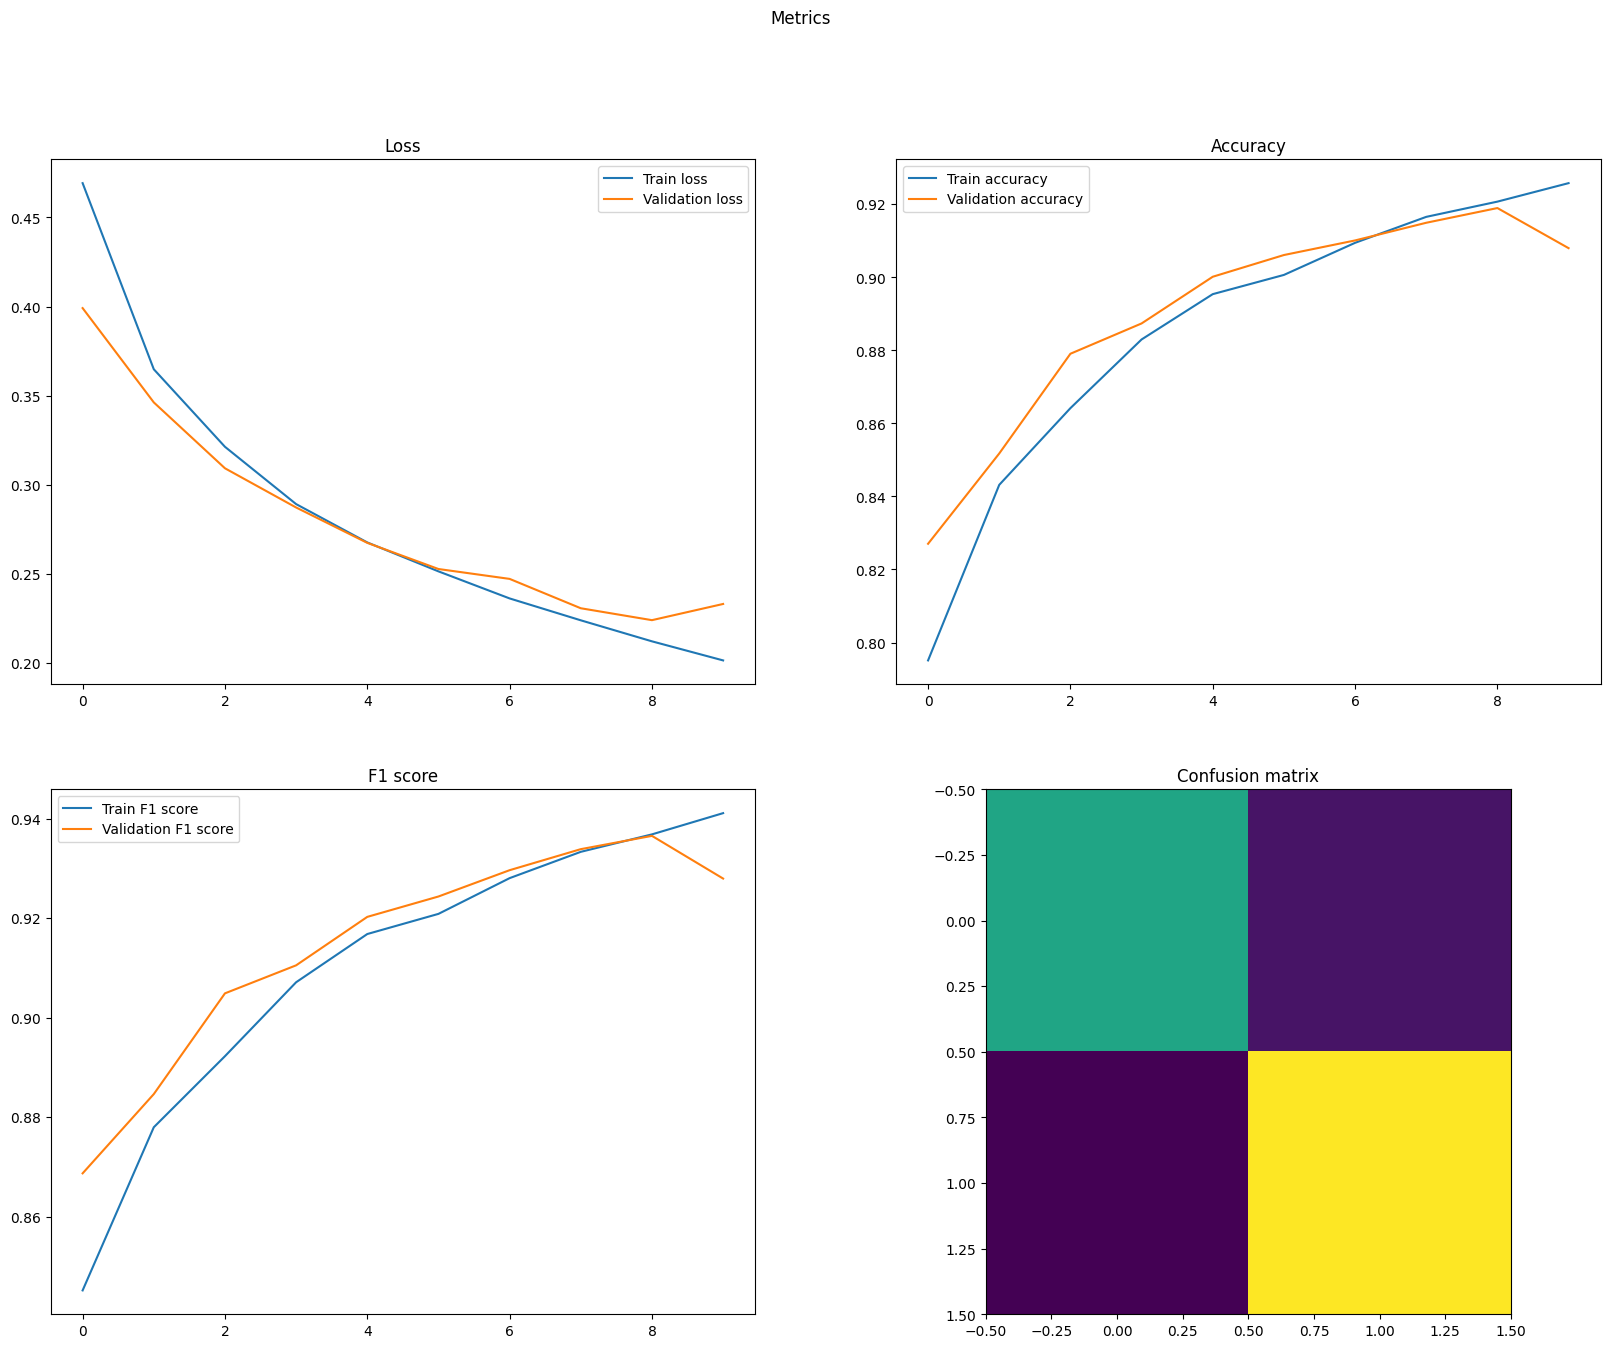

In [10]:
# noinspection PyShadowingNames
def plot_metrics(metrics: dict[str, list]):
    fig, ax = plt.subplots(2, 2, figsize=(20, 15))
    loss_ax, acc_ax, f1_ax, cm_ax = ax.flatten()
    fig.suptitle("Metrics")
    loss_ax.plot(metrics["train_loss"], label="Train loss")
    loss_ax.plot(metrics["val_loss"], label="Validation loss")
    loss_ax.set_title("Loss")
    loss_ax.legend()
    acc_ax.plot(metrics["train_acc"], label="Train accuracy")
    acc_ax.plot(metrics["val_acc"], label="Validation accuracy")
    acc_ax.set_title("Accuracy")
    acc_ax.legend()
    f1_ax.plot(metrics["train_f1"], label="Train F1 score")
    f1_ax.plot(metrics["val_f1"], label="Validation F1 score")
    f1_ax.set_title("F1 score")
    f1_ax.legend()
    cm_ax.imshow(metrics["train_confusion_matrix"][-1], cmap='viridis')
    cm_ax.set_title("Confusion matrix")
    # Save the plot
    plt.savefig("metrics.png")
    plt.show()

plot_metrics(train_metrics)

# Testing the model

In [12]:
def test(model: nn.Module, test_loader: DataLoader, criterion: nn.Module):
    model.eval()
    metrics = {
        "test_loss": 0,
        "test_acc": 0,
        "test_f1": 0,
        "test_confusion_matrix": []
    }
    total_loss = 0
    total_acc = 0
    total_f1 = 0
    with torch.no_grad():
        for batch, (images, labels) in enumerate(test_loader):
            # Move images and labels to the device
            images, labels = images.to(device), labels.to(device)
            # Forward pass
            outputs = model(images)
            # Calculate the loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            # Get the predicted labels
            predicted = torch.round(outputs.cpu().detach())
            # Calculate the accuracy per batch
            total_acc += accuracy_score(labels.cpu(), predicted)
            # Calculate the F1 score per batch
            total_f1 += f1_score(labels.cpu(), predicted)
            # Calculate the confusion matrix only for the first batch
            if batch == 0:
                metrics["test_confusion_matrix"].append(confusion_matrix(labels.cpu(), predicted))

        # Calculate the average metrics
        metrics["test_loss"] = total_loss / len(test_loader)
        metrics["test_acc"] = total_acc / len(test_loader)
        metrics["test_f1"] = total_f1 / len(test_loader)

        print(f"Test metrics: {metrics}")
    return metrics

test_metrics = test(model, test_loader, criterion)

Test metrics: {'test_loss': 0.20543324786263542, 'test_acc': 0.9184167275383491, 'test_f1': np.float64(0.9323594160503555), 'test_confusion_matrix': [array([[24,  4],
       [ 1, 35]])]}


# Save the model

In [14]:
torch.save(model, "fire_cnn.pth")